## Use this script to load the 1024 px Ronchigram, resize, add noise, then pair with emittance and aberratio coeffs, and combine them into one single file
The 1024 px Ronchigram and aberration functions are too big, reshape the Ronchigrams to 128 px, add noise, then save it together with emittance from aberration function and the aberration coefficients. Both emittance and abr coeff are just numbers, should be very small in size.

In [1]:
# %matplotlib nbagg

# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
# import cv2
import glob
from random import randrange
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Process simulated Ronchigram with random cutoff aperture and noise
Cutoff aperture is added here, simulated Ronchigram from Matlab has no cutoff aperture.

In [187]:
# modified version, include different convergence angle and different noise level
filelist = glob.glob('/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/*highCs_40limit*.mat')
print(filelist)

['/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_3.mat', '/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_4.mat', '/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_8.mat', '/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_2.mat', '/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_5.mat', '/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRa

In [234]:
# Load 10 simulated data, assign random cutoff aperture and noise level, aperture option is not in use
ronch = []
abr_coeff = []
emit = []
aperture = []
defocus = []

# Acquisition condition for Ronchigrams used when simulating
simdim = 40
numpx = 128
current = 150 # current=30 for 70um aperture, current = 138 for 150 aperture
emit_range = 40

# range in mrad for the cutoff aperture, generate list for aperture size in step size of 1 mrad
# Currently not in use, no limiting aperture in the current simulation
aperture_min = 25
aperture_max = 40
aperture_list = np.arange(aperture_min, aperture_max + 1)

# list for dwell time used in simulation, the large number at the first place is used to simulate noiseless situation
dtime_list = [32, 64, 128, 100000]
# dtime_list = [100000]
for i in range(8):
    temp = sio.loadmat(filelist[i])
    abr_func = temp['chi0_final']
    for j in range(len(temp['aberration_final']['mag'][0])):
        # randomly select aperture size and dwell time from the list:
        ap_size = aperture_list[randrange(len(aperture_list))]
        aperture.append(ap_size)
        dtime = dtime_list[randrange(len(dtime_list))]
        
        # append the aberration coefficient and emittance, the emittance is also calculated with 40 mrad cutoff range.
        abr_coeff.append(temp['aberration_final']['mag'][0][j])
        emit.append(CalcEmittance_new(abr_func[:,:,j], simdim, emit_range))  # calculate emittance within emit_range mrad
        
        # single ronchigram with mask applied, mask is not currently in use
        temp2 = temp['ronch_final'][:,:,j]
#         mask = mask_generator(temp2, simdim, ap_size)  # disable the mask generator if trying to save the whole Ronch
#         temp2 = temp2 * mask
        
        ronch.append(reshape_noise_frame(temp2, numpx, current, dtime))
        
        # save the defocus
        defocus.append(np.abs(temp['aberration_final']['mag'][0][j][0][0]))
    print(filelist[i])

/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_3.mat
/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_4.mat
/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_8.mat
/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_2.mat
/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_highCs_40limit_128px_x5000_5.mat
/home/chenyu/Desktop/ML_Alignment/AberrationMeasurement/RonchigramSimulation/ronchigram-matlab-master/CoarseCNN_data/FullRandom_NoAperture_h

In [235]:
np.save('TrainingData_CoarseCNN/FullRandom_NoAperture_HighCs_60limit_multiNoise_30pA_emit_x40000.npy',emit)
np.save('TrainingData_CoarseCNN/FullRandom_NoAperture_HighCs_60limit_multiNoise_30pA_128pxRonch_x40000.npy',ronch)
np.save('TrainingData_CoarseCNN/FullRandom_NoAperture_HighCs_60limit_multiNoise_30pA_defocus_x40000.npy',defocus)
np.save('TrainingData_CoarseCNN/FullRandom_NoAperture_HighCs_60limit_multiNoise_30pA_abr_coeff_x40000.npy',abr_coeff)

In [32]:
del temp, abr_func

In [152]:
abr_list = []
for j in range(len(temp['aberration_final']['mag'][0])):
    abr_list.append(np.abs(temp['aberration_final']['mag'][0][j][0][5]))

ValueError: x and y must be the same size

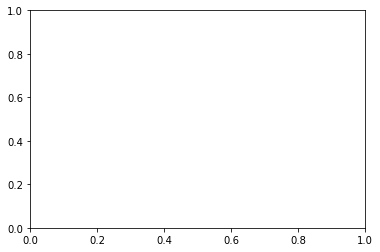

In [164]:
# np.save('FullRandom_25-40aperture_60limit_128px_multiNoise_30pA_convAngle_50000x.npy',aperture)
plt.scatter(np.asarray(defocus),np.asarray(abr_list), s=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Defocus (Angstrom)',fontsize=20)
plt.ylabel('$\epsilon$ (pm\u2022rad)',fontsize=20,rotation=90)
print(np.amax(defocus))

## Data Check
1. Visulize the whole index list, see if that is random
2. Visulize the ronchigram correspond to the smallest and largest emittance, check the match between Ronchigram and emit
3. Visulize the realtionship between emittance and single aberration coeff, check the match between emit and abr coeff

In [2]:
emit = np.load('TrainingData_CoarseCNN/FullRandom_NoAperture_60limit_multiNoise_30pA_emit_x40000.npy')
ronch = np.load('TrainingData_CoarseCNN/FullRandom_40Aperture_60limit_multiNoise_30pA_128pxRonch_x40000.npy')

In [229]:
sort_idx = np.argsort(emit)
print(np.amin(emit))
print(np.amax(emit))

0.017718489224745452
1094.6345201035379


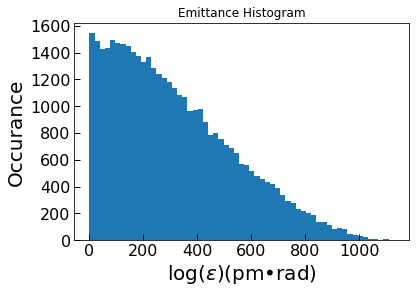

In [237]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(emit, bins='auto')  # arguments are passed to np.histogram
plt.title("Emittance Histogram")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('log($\epsilon$)(pm\u2022rad)',fontsize=20)
plt.ylabel('Occurance',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

0.6192845810613179
1029.9926397025908


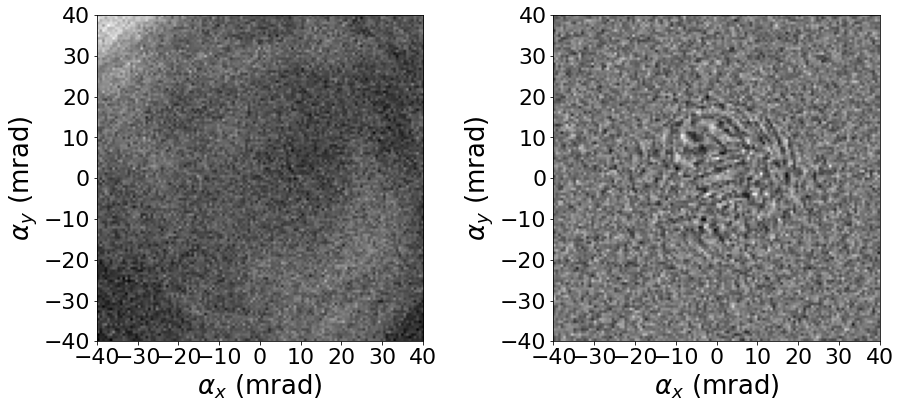

In [238]:
# show examples of Ronchigrams with minimum and maximum emittance
plt.figure(figsize=[15,6])
plt.subplot(121)
plt.imshow(ronch[sort_idx[7]], extent=[-40,40,-40,40], cmap='gray')
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$",fontsize=26)
plt.ylabel(r"$\alpha_y \ \mathrm{(mrad)}$",fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.colorbar()
print(emit[sort_idx[7]])

plt.subplot(122)    
plt.imshow(ronch[sort_idx[-10]], extent=[-40,40,-40,40], cmap='gray')
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$",fontsize=26)
plt.ylabel(r"$\alpha_y \ \mathrm{(mrad)}$",fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
print(emit[sort_idx[-10]])
# plt.colorbar()

Text(0, 0.5, '$\\epsilon^2$')

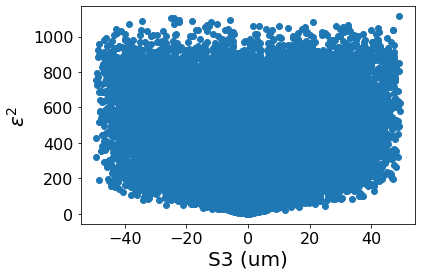

In [185]:
# scatter plot emittance against one of the aberration coefficients
s3 = []
for i in range(len(abr_coeff)):
    s3.append(abr_coeff[i][0][5])
plt.scatter(np.asarray(s3), np.asarray(emit))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('S3 (um)',fontsize=20)
plt.ylabel('$\epsilon^2$',fontsize=20,rotation=90)

## Aux functions

In [2]:
def CalcEmittance(abr, simdim, ap_size):
    imdim = abr.shape[0]
    abr_gradient = np.gradient(abr)
    x = np.linspace(-simdim/1000, simdim/1000, imdim)
    y = np.linspace(-simdim/1000, simdim/1000, imdim)
    xv, yv = np.meshgrid(x, y)
    apt_fact = 1/math.pi/(ap_size/1000)/(ap_size/1000) # factor from aperture
    apt_mask = np.sqrt(xv*xv + yv*yv) < ap_size/1000 # aperture mask
    apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask
    # calculte the three integrals numerically by adding up within aperture mask
    emit_1 = np.sum(apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1]))
    emit_2 = np.sum(apt_mask*(xv*xv + yv*yv))
    emit_3 = np.sum(apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv))
    emit = emit_1 * emit_2 - emit_3**2
    return emit

In [3]:
def CalcEmittance_new(abr, simdim, ap_size):

    imdim = abr.shape[0]
    px_size = simdim / (imdim/2) # pixel size in mrad
    px_size = px_size / 1000 # pixel size in rad

    abr_gradient = np.gradient(abr)
    abr_gradient[0], abr_gradient[1] = abr_gradient[0] / px_size, abr_gradient[1] / px_size

    x = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    y = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    xv, yv = np.meshgrid(x, y)

    apt_fact = 1/math.pi/(ap_size/1000)/(ap_size/1000) # factor from aperture, correspond to A^2
    apt_mask = np.sqrt(xv*xv + yv*yv) < (ap_size / 1000) # aperture mask
    apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask

    # calculte the three integrals numerically by adding up within aperture mask
    emit_1 = np.sum(apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1])) * px_size**2
    emit_2 = np.sum(apt_mask*(xv*xv + yv*yv)) * px_size**2
    emit_3 = np.sum(apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv)) * px_size**2
    emit = np.sqrt(emit_1 * emit_2 - emit_3 * emit_3)

    return emit

In [4]:
# Function to resample input array (arr) to new_shape, only work when the new shape is integer times smaller than original 
# array.
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [5]:
def reshape_noise(arr, side_length, current, dtime):
    # optional: normalize the rochigrams, resample to 128x128 px, then add noise
    arr_reshape = np.zeros((side_length,side_length,arr.shape[2]))
    for i in range(arr.shape[2]):
        temp = arr[:,:,i]
        temp = rebin(temp,[side_length, side_length])
        temp = temp / np.sum(temp)
        temp = temp * current * dtime / 1.6 * 10000   # convert to number of electrons
        temp = np.random.poisson(temp)
        arr_reshape[:,:,i] = temp
    return arr_reshape

In [186]:
def reshape_noise_frame(frame, side_length, current, dtime):
# reshape and add noise for a single frame
    temp = rebin(frame,[side_length, side_length])
    # No need to normalize if the input data is already normalized
#     temp = temp / np.sum(temp)
    temp = temp * current * dtime / 1.6 * 10000   # convert to number of electrons
    temp = np.random.poisson(temp)
    return temp

In [7]:
def mask_generator(stack, simdim, ap_size):
    imdim = stack.shape[0]
    x = np.linspace(-simdim/1000, simdim/1000, imdim)
    y = np.linspace(-simdim/1000, simdim/1000, imdim)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size/1000 # aperture mask
    return apt_mask

In [8]:
def pi_4_radius(probe, simdim):
    probe_binary = probe > 3.14/4
    radius = simdim # start with the maximum radius
    mask = mask_generator(probe, simdim, radius)
    overlap = np.sum(probe_binary * mask)
    while overlap > 0:
        radius = radius - 1
        mask = mask_generator(probe, simdim, radius)
        overlap = np.sum(probe_binary * mask)
    return radius

In [9]:
def PhaseDiff(probe, simdim, ap_size):
    mask = mask_generator(probe, simdim, ap_size)
    probe_mask = probe * mask
    return np.amax(probe_mask), np.sum(np.abs(probe_mask)) / np.sum(mask)

## Emittance with Jacobian determinant included
Turned out not necessary, see page 51 of my notebook for discussion of how to derive Paul's expression of emittance, which is actually correct.

In [249]:
abr = abr_func[:,:,500]
simdim = 60
emit_range = 40
imdim = abr.shape[0]
px_size = simdim/(imdim/2)/1000 # px size in rad

# calculate the gradient of aberration in unit of [1/rad]
# abr_gradient[0] is the gradient along dimension 1
# abr_gradient are two matrices along x and y, check whether rotated here!
abr_gradient = np.gradient(abr)
abr_gradient[0], abr_gradient[1] = abr_gradient[0]/px_size, abr_gradient[1]/px_size  # gradient normalized by pixel size

# Calculate the four elements of Jacobian matrix and the determinant for each pixel in reciprocal space
# do not need to normalize by pixel size again here?
# Jdet tells how much (x,y) changes when (kx, ky) change by 1 mrad^2
J11 = np.gradient(abr_gradient[1])[1]/px_size # how much x change in \lambda/2\pi when kx change by 1 mrad
J12 = np.gradient(abr_gradient[1])[0]/px_size
J21 = np.gradient(abr_gradient[0])[1]/px_size
J22 = np.gradient(abr_gradient[0])[0]/px_size
Jdet = J11*J22-J12*J21

# Calculate the Jacobian matrix for the integral over both real space and reciprocal space
# how much volume in (x,y,kx,ky) change for unit area in (kx,ky)
J_11 = (J11*J11 + J21*J21)
J_12 = (J11*J12 + J21*J22) 
J_22 = (J12*J12 + J22*J22)
J_det = np.sqrt(J_11*J_22 - J_12*J_12) # dominated by the 1 in J_11 and J_22

x = np.linspace(-simdim/1000, simdim/1000, imdim)
y = np.linspace(-simdim/1000, simdim/1000, imdim)
xv, yv = np.meshgrid(x, y)
apt_mask = np.sqrt(xv*xv + yv*yv) < ap_size/1000 # aperture mask
# apt_fact = 1/math.pi/(ap_size)/(ap_size) # factor from aperture
# apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask

# Also need to include the pixel size when using sum to calculate integral!
emit_1 = np.sum((abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1]) * np.abs(Jdet) * apt_mask)
emit_2 = np.sum((xv*xv + yv*yv) * apt_mask)
emit_3 = np.sum((abr_gradient[0]*yv + abr_gradient[1]*xv) * J_det * apt_mask)
print(emit_1, emit_2, emit_3)
print(emit_1 * emit_2 - emit_3**2)
# plt.imshow(apt_mask * (emit_1 * np.abs(Jdet) * emit_2 - emit_3 * emit_3 * J_det * J_det))
# plt.colorbar()

4.809180233915493e+18 4.481514985429971 53243447862547.766
-2.834864718739429e+27


## Test debugged emittance calculation

(128, 128)
(128, 128)


Text(0, 0.5, '$r_{xy}$ ($\\mu$m)')

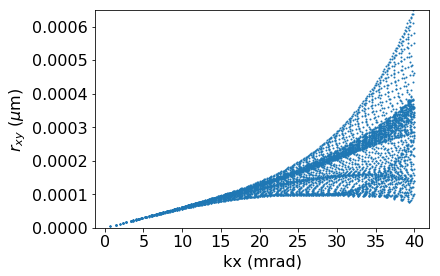

In [29]:
x_abs = np.sqrt(abr_gradient[0]**2 + abr_gradient[1]**2) # in normalized length
x_abs = x_abs * 1.98e-12 /2 / 3.1516 # in meter
k_abs = np.sqrt(xv**2 + yv**2) # in radian
print(k_abs.shape)
print(x_abs.shape)
index = np.where(k_abs < 0.040)
plt.scatter(k_abs[index]*1000,x_abs[index]*1e6,s=1)

plt.ylim([0, np.amax(x_abs[index])*1e6])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('kx (mrad)', fontsize = 16)
plt.ylabel('$r_{xy}$ ($\mu$m)', fontsize = 16)

In [4]:
abr = abr_func[:,:,500]
simdim = 60
emit_range = 40
ap_size = 40

imdim = abr.shape[0]
px_size = simdim / (imdim/2) # pixel size in mrad
px_size = px_size / 1000 # pixel size in rad

abr_gradient = np.gradient(abr)
abr_gradient[0], abr_gradient[1] = abr_gradient[0] / px_size, abr_gradient[1] / px_size

x = np.linspace(-simdim / 1000, simdim / 1000, imdim)
y = np.linspace(-simdim / 1000, simdim / 1000, imdim)
xv, yv = np.meshgrid(x, y)

apt_fact = 1/math.pi/(ap_size/1000)/(ap_size/1000) # factor from aperture, correspond to A^2
apt_mask = np.sqrt(xv*xv + yv*yv) < (ap_size / 1000) # aperture mask
apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask

# calculte the three integrals numerically by adding up within aperture mask
emit_1 = np.sum(apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1])) * px_size**2
emit_2 = np.sum(apt_mask*(xv*xv + yv*yv)) * px_size**2
emit_3 = np.sum(apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv)) * px_size**2
emit = np.sqrt(emit_1 * emit_2 - emit_3 * emit_3)
print(emit_1, emit_2, emit_3, emit)

406989.47351848305 0.0007836056350395812 4.158695917052694 17.36733984006661


0.0007836056350395812


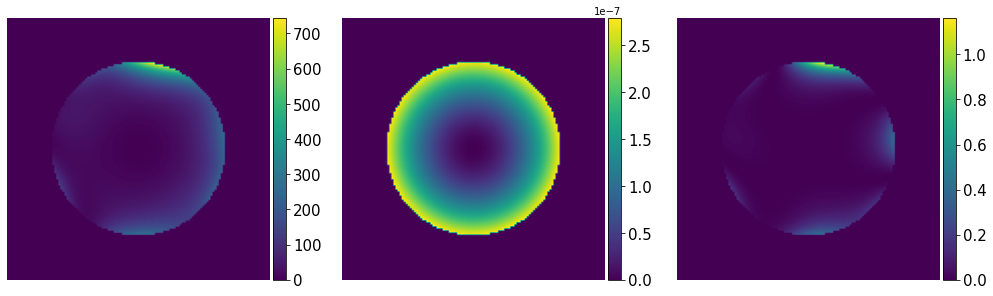

In [109]:
temp1 = apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1])*px_size*px_size
temp2 = apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv)*(abr_gradient[0]*yv + abr_gradient[1]*xv)*px_size*px_size
temp3 = apt_mask*(xv*xv + yv*yv)*px_size*px_size

print(np.sum(temp3))

fig = plt.figure(figsize=(17,5))

ax = plt.subplot(131)
im = ax.imshow(temp1)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax = plt.subplot(132)
im = plt.imshow(temp3)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax = plt.subplot(133)
im = plt.imshow(temp2)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=15)

## Plot the relationship between emittance and other conventional metrics

In [15]:
# Load 10 simulated data pair with varying defocus and A1, other aberrations fixed at zero
ronch = []
abr_coeff = []
emit = []
emit_new = []
simdim = 60
emit_range = 40
current = 30
c3 = []

i = 0
temp = sio.loadmat('NoAperture_validation/FullRandom_NoAperture_60limit_128px_x5000_validation.mat')
abr_func = temp['chi0']
for j in range(len(temp['aberration']['mag'][0])):
    abr_coeff.append(temp['aberration']['mag'][0][j])
    emit.append(CalcEmittance(abr_func[:,:,j], simdim, emit_range))
    emit_new.append(CalcEmittance_new(abr_func[:,:,j], simdim, emit_range))
    ronch.append(reshape_noise_frame(temp['ronch'][:,:,j],128, current, 10000))

In [12]:
# pi/4 radius
pi_4 = []
max_phasediff = []
mean_phasediff = []
for i in range(abr_func.shape[-1]):
    pi_4.append(pi_4_radius(abr_func[:,:,i], simdim))
    results = PhaseDiff(abr_func[:,:,i], simdim, 40)
    max_phasediff.append(results[0])
    mean_phasediff.append(results[1])

3.4408602150537666


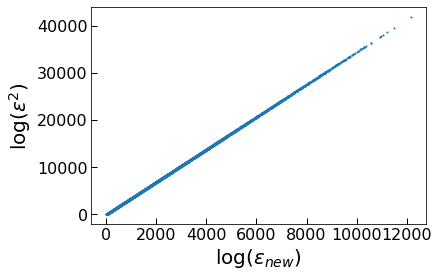

In [75]:
# Relationship between log emittance square and max phase difference
fig = plt.figure()
ax = fig.add_subplot()
# ax.scatter(np.log(np.asarray(emit_new)), np.log(np.sqrt(emit)),s=1)
ax.scatter(np.asarray(emit_new)*0.31*1000, np.sqrt(emit),s=1)
z = np.polyfit(np.asarray(emit_new)*0.31*1000, np.asarray(np.sqrt(emit)), 1)
print(z[0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('log($\epsilon_{new}$)',fontsize=20)
plt.ylabel('log($\epsilon^2$)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

In [111]:
print(np.amin(emit_new)*0.31*1000)
print(np.amax(emit_new)*0.31*1000)

4.913992263202847
12166.152390169225


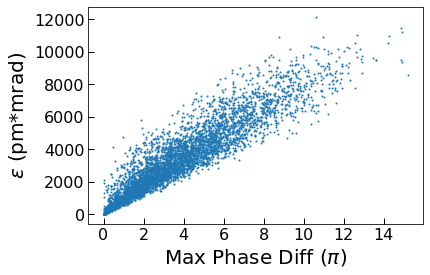

In [83]:
# Relationship between log emittance square and max phase difference
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.asarray(max_phasediff)/math.pi, np.asarray(emit_new)*0.31*1000,s=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Max Phase Diff ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon$ (pm*mrad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

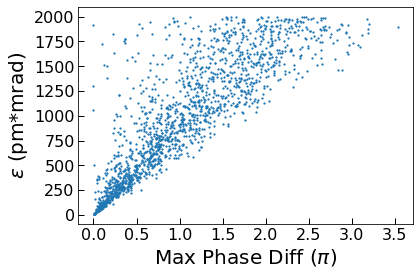

In [97]:
# Relationship between log emittance square and max phase difference
# Zoomed in for low emittance part
emit_new = np.asarray(emit_new)
max_phasediff = np.asarray(max_phasediff)
idx = np.where(emit_new*0.31*1000 < 2000)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.asarray(max_phasediff[idx])/math.pi, emit_new[idx] * 0.31*1000,s=1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Max Phase Diff ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon$ (pm*mrad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

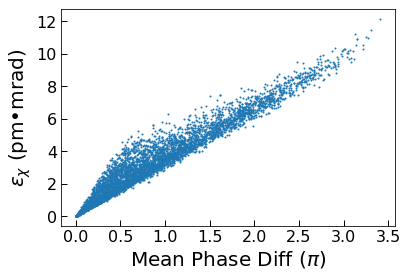

In [22]:
# Relationship between log emittance square and mean phase difference
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(np.asarray(mean_phasediff)/math.pi, np.asarray(emit_new)*0.31,s=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Mean Phase Diff ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon_\chi$ (pm$\u2022$mrad)',fontsize=20,rotation=90)
plt.tick_params(direction='in', length=6, width=1)

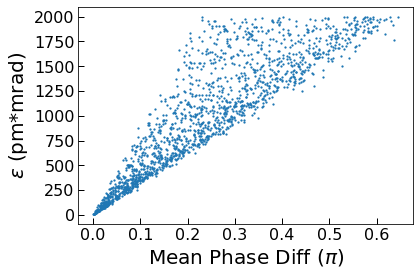

In [102]:
# Relationship between log emittance square and mean phase difference
fig = plt.figure()
emit = np.asarray(emit)
mean_phasediff = np.asarray(mean_phasediff)
idx = np.where(emit_new*0.31*1000 < 2000)

ax = fig.add_subplot()
ax.scatter(np.asarray(mean_phasediff[idx])/math.pi, emit_new[idx]*0.31*1000,s=1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Mean Phase Diff ($\pi$)',fontsize=20)
plt.ylabel('$\epsilon$ (pm*mrad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

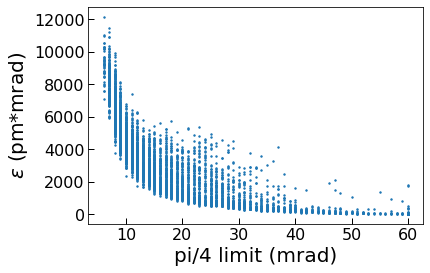

In [103]:
# Relationship between log emittance square and pi/4 radius
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(pi_4, emit_new*0.31*1000,s=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('pi/4 limit (mrad)',fontsize=20)
plt.ylabel('$\epsilon$ (pm*mrad)',fontsize=20,rotation=90)
ax.tick_params(direction='in', length=6, width=1)

In [47]:
np.save('NoAperture_validation/FullRandom_NoAperture_60limit_1us_pi_4limit_x5000_validation.npy',pi_4)
np.save('NoAperture_validation/FullRandom_NoAperture_60limit_1us_maxPhaseDiff_x5000_validation.npy',max_phasediff)
np.save('NoAperture_validation/FullRandom_NoAperture_60limit_1us_meanPhaseDiff_x5000_validation.npy',mean_phasediff)